# Setup

In [ ]:
# Get images from the fast.ai book
!git clone https://github.com/fastai/fastbook.git
!mv fastbook/images .
!ls images
!rm -rf fastbook

Cloning into 'fastbook'...
remote: Enumerating objects: 2211, done.
remote: Total 2211 (delta 0), reused 0 (delta 0), pack-reused 2211
Receiving objects: 100% (2211/2211), 75.30 MiB | 33.02 MiB/s, done.
Resolving deltas: 100% (1355/1355), done.
mv: cannot move 'fastbook/images' to './images': Directory not empty
0_jupyter.png	     att_00044.png		   chapter4_overfit.png
analytics_chain.gif  att_00045.png		   chapter7_neuron.png
att_00000.png	     att_00046.png		   chapter9_baseconv.svg
att_00001.png	     att_00047.png		   chapter9_bottleneck.png
att_00002.png	     att_00048.png		   chapter9_cat_conv.png
att_00003.png	     att_00049.png		   chapter9_conv_basic.png
att_00004.png	     att_00050.png		   chapter9_conv_pad.png
att_00005.png	     att_00051.png		   chapter9_conv_rgb.png
att_00006.png	     att_00052.png		   chapter9_conv_stride.png
att_00007.png	     att_00053.png		   chapter9_loss_landscape.png
att_00008.png	     att_00054.png		   chapter9_nopadconv.svg
att_00009.png	     att_0

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [ ]:
(path/"images").ls()

(#7393) [Path('images/english_setter_69.jpg'),Path('images/scottish_terrier_120.jpg'),Path('images/basset_hound_113.jpg'),Path('images/miniature_pinscher_87.jpg'),Path('images/pomeranian_1.jpg'),Path('images/Persian_68.jpg'),Path('images/japanese_chin_39.jpg'),Path('images/english_setter_107.jpg'),Path('images/Birman_128.jpg'),Path('images/staffordshire_bull_terrier_26.jpg')...]

In [ ]:
fname = (path/"images").ls()[0]

In [ ]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['english_setter']

In [ ]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

## Presizing

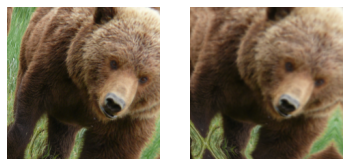

In [ ]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

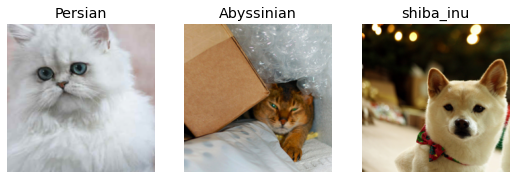

In [ ]:
dls.show_batch(nrows=1, ncols=3)

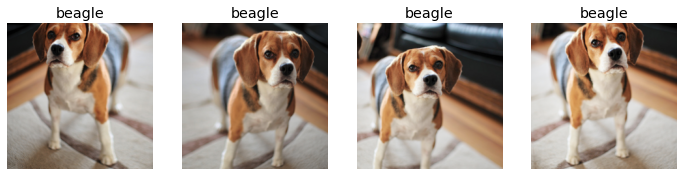

In [ ]:
# shows same images with different augmentations to test augmentations
dls.show_batch(nrows=1, ncols=4, unique=True)

In [ ]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))

try:
  pets1.summary(path/"images")
except Exception as inst:
  print("\n--------------------------\nCaught exception.....\n--------------------------\n")
  print(type(inst))    # the exception instance
  print(inst.args)     # arguments stored in .args
  print(inst)          # __str__ allows args to be printed directly,
                        # but may be overridden in exception subclasses

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/beagle_102.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=333x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/beagle_102.jpg
    applying partial gives
      beagle
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(15)

Final sample: (PILImage mode=RGB size=333x500, TensorCategory(15))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.499680,0.310199,0.107578,02:00


epoch,train_loss,valid_loss,error_rate,time
0,0.540755,0.285897,0.089986,02:34
1,0.317576,0.186239,0.066982,02:33


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Cross-Entropy Loss

### Viewing Activations and Labels

In [ ]:
x,y = dls.one_batch()
# x,y = first(dls.train) # alternative approach

In [ ]:
y

TensorCategory([15, 27,  7, 19, 23, 11, 24, 11,  4, 12, 21, 27, 25,  6, 14, 19,  6,  5,  4, 20, 31, 30,  7, 13, 15, 18, 23,  3, 27, 14,  7, 11, 16, 34,  4, 21,  0, 24, 24, 19, 19, 27,  4, 15, 29, 11,  8, 32,
        21, 15,  6, 30, 30, 25, 20, 29,  7, 11,  5, 24, 11, 36, 23, 13], device='cuda:0')

In [ ]:
dls.vocab[0]

'Abyssinian'

In [ ]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([1.0687e-05, 3.5276e-06, 1.6798e-06, 7.7018e-06, 4.4103e-07, 6.1848e-06, 2.2324e-07, 6.6795e-07, 2.6780e-06, 1.1213e-06, 7.3634e-06, 2.4150e-06, 4.9422e-06, 7.7768e-06, 5.1763e-04, 9.9881e-01,
        2.1962e-06, 8.3247e-06, 1.6425e-06, 1.1129e-04, 1.3312e-04, 1.2372e-05, 3.3468e-07, 1.6909e-07, 2.8858e-07, 7.7827e-06, 2.7774e-04, 2.4952e-07, 4.6573e-07, 8.7533e-07, 2.3983e-05, 2.6363e-06,
        2.0281e-07, 9.7785e-06, 5.5319e-06, 8.5728e-06, 8.3001e-06])

In [ ]:
len(preds[0]),preds[0].sum()

(37, TensorBase(1.))

### Softmax

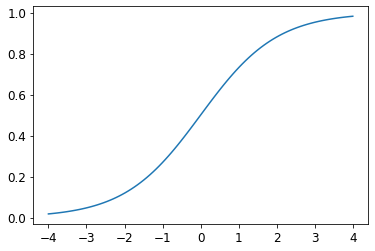

In [ ]:
plot_function(torch.sigmoid, min=-4,max=4)

In [ ]:
#hide
torch.random.manual_seed(42);

In [ ]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [ ]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [ ]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [ ]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])

In [ ]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [ ]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [ ]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [ ]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

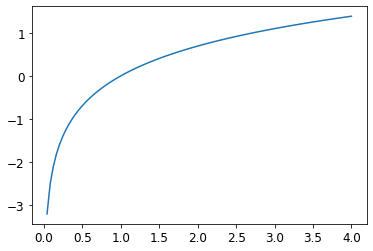

In [ ]:
plot_function(torch.log, min=0,max=4)

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(1.8045)

In [ ]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [ ]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

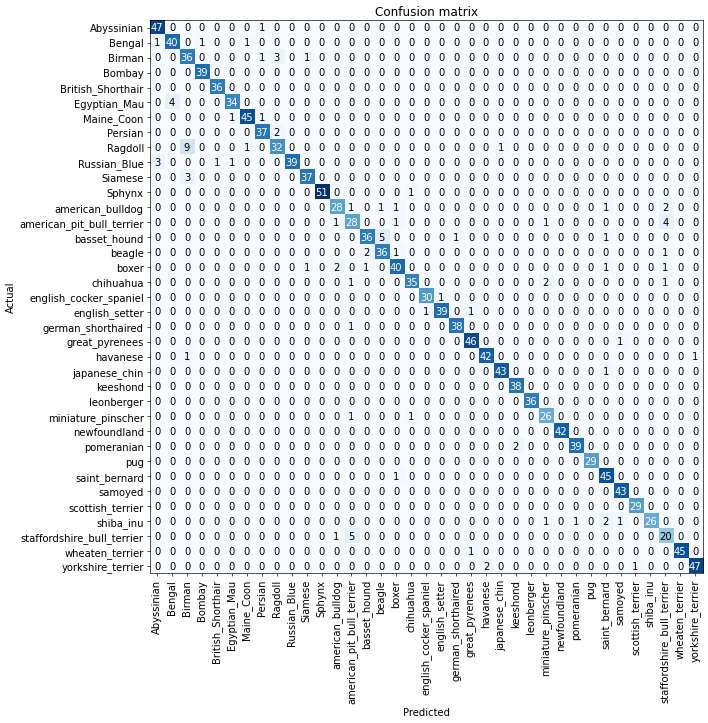

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 9),
 ('basset_hound', 'beagle', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5)]

## Improving Our Model

### The Learning Rate Finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.497700,4.760169,0.495264,02:05


epoch,train_loss,valid_loss,error_rate,time
0,3.505397,1.771865,0.510149,02:37


In [ ]:
doc(learn.lr_find)

,Type,Default
start_lr,float,1e-07
end_lr,int,10
num_it,int,100
stop_div,bool,True
show_plot,bool,True
suggest_funcs,function,<function valley at 0x7f2deb040c20>


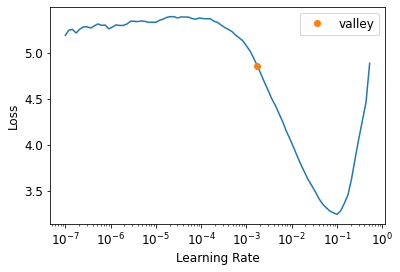

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# lr_min,lr_steep = learn.lr_find()
lr = learn.lr_find()

In [ ]:
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Learning rate: {lr}")

Learning rate: SuggestedLRs(valley=0.001737800776027143)


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.363643,0.326806,0.103518,02:03


epoch,train_loss,valid_loss,error_rate,time
0,0.544276,0.371277,0.117727,02:38
1,0.331383,0.192670,0.066982,02:37


### Unfreezing and Transfer Learning

In [ ]:
learn.fine_tune??

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.137768,0.312662,0.105548,02:05
1,0.521085,0.198402,0.062923,02:04
2,0.325220,0.193598,0.062923,02:04


In [ ]:
learn.unfreeze()

SuggestedLRs(valley=1.4454397387453355e-05)

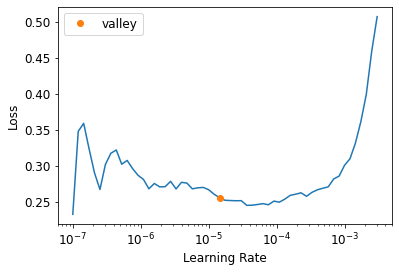

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.261319,0.176935,0.061570,02:38
1,0.254970,0.176660,0.062246,02:37
2,0.236614,0.167770,0.057510,02:38
3,0.203234,0.171967,0.056834,02:37
4,0.179800,0.165710,0.058863,02:38
5,0.184843,0.163510,0.058187,02:37


### Discriminative Learning Rates

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.121137,0.280630,0.096752,02:06
1,0.507133,0.239226,0.078484,02:04
2,0.342407,0.188109,0.057510,02:05


epoch,train_loss,valid_loss,error_rate,time
0,0.256943,0.185146,0.058187,02:38
1,0.255270,0.176645,0.060217,02:38
2,0.235852,0.165891,0.054127,02:40
3,0.216006,0.160333,0.051421,02:39
4,0.183671,0.155811,0.052097,02:40
5,0.175299,0.157208,0.049391,02:40
6,0.157267,0.151460,0.048714,02:40
7,0.149750,0.154706,0.051421,02:39
8,0.126829,0.152790,0.052097,02:39
9,0.131850,0.153397,0.049391,02:39


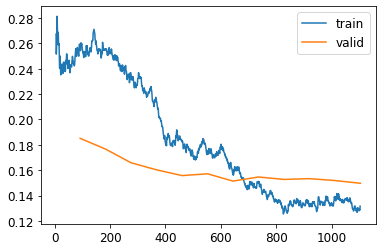

In [ ]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.287135,0.265015,0.097429,02:23
1,0.582545,0.260160,0.076455,02:24
2,0.415851,0.237242,0.081867,02:24


epoch,train_loss,valid_loss,error_rate,time
0,0.285360,0.215011,0.070365,03:10
1,0.309846,0.285622,0.083221,03:10
2,0.259733,0.256847,0.077808,03:11
3,0.162117,0.216582,0.062923,03:09
4,0.092844,0.190669,0.053451,03:09
5,0.069029,0.184935,0.051421,03:08


## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?

  It's known as *presizing*.  Because the first step creates something square and always the same size the second step can happen on the GPU.  Typically, things like image warping, rotating, etc can be quite slow so there is a performance boost doing this on the GPU.

1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?

  "- individual files representing items of data, such as text documents or images, possibly organised into folders or with filenames representing information about those items, or
  - a table of data, such as in CSV format, where each row is an item, each row which may include filenames providing a connection between the data in the table and data in other formats such as text documents and images"

1. Look up the documentation for `L` and try using a few of the new methods that it adds.

  Most functions and methods in fastai which return a collection use a class called `L` (which is kind of like an enhanced version of the ordinary Python `list` type

In [ ]:
doc(L)

,Type,Default
items,NoneType,None
rest,,
use_list,bool,False
match,NoneType,None


5. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.

  [pathlib docs](https://docs.python.org/3/library/pathlib.html)

In [ ]:
from pathlib import Path

# List subdirectories
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

[Path('.config'),
 Path('gdrive'),
 Path('images'),
 Path('models'),
 Path('sample_data')]

In [ ]:
# List csv files in directory tree

list(p.glob('**/*.csv'))

[Path('sample_data/california_housing_train.csv'),
 Path('sample_data/mnist_test.csv'),
 Path('sample_data/mnist_train_small.csv'),
 Path('sample_data/california_housing_test.csv')]

In [ ]:
# ! ls -la /etc

In [ ]:
# Navigating inside a directory tree
p = Path('/etc')
q = p / 'localtime'
q

Path('/etc/localtime')

In [ ]:
q.resolve()

Path('/usr/share/zoneinfo/UCT')

In [ ]:
# Querying path properties
q.exists()

True

In [ ]:
q.is_dir()

False

In [ ]:
# Opening a file
p = Path('.')
q = p / 'sample_data' / 'README.md'

with q.open() as f: f.readline()

6. Give two examples of ways that image transformations can degrade the quality of the data.

  - reflection padding artifacts
  - disappearing features
  - multiple interpolations can repeatedly blur an image

  FastAI does all co-ordinate transforms not on the actual pixels but keeps track of pixel locations in a non-destructive way and performs all co-ordinate transforms at once (one interpolation) do minimize these effects (part of presizing routine).

1. What method does fastai provide to view the data in a `DataLoaders`?

  `dls.show_batch(nrows=1, ncols=3)`

  `dls.show_batch(nrows=1, ncols=4, unique=True)`
  
  shows same images with different augmentations to test augmentations

1. What method does fastai provide to help you debug a `DataBlock`?

  The `summary` method.  Note: current version seems to still try the datablock and will crash / throw an exception.  Consider wrapping in a try/catch if using just for debugging purposes.

1. Should you hold off on training a model until you have thoroughly cleaned your data?

  Most people say yes.  FastAI suggests that using an initial model will help you clean a dataset (confusion matrices, outputting low confidence answer to see if it was mislabeled, etc).  Use model trained on okay data, clean, then retrain on clean data.

1. What are the two pieces that are combined into cross-entropy loss in PyTorch?

  - softmax
  - log likelihood

1. What are the two properties of activations that softmax ensures? Why is this important?

  2-class sigmoid:

  ```
  diff = acts[:,0]-acts[:,1]
  diff
  
  diff.sigmoid()

  torch.stack([diff.sigmoid(), 1-diff.sigmoid()], dim=1)
  ```

  multi-class sigmoid:

  ```
  def softmax(): return exp(x) / exp(x).sum(dim=1, keepdim=True)
  ```

  Softmax properties:
  - all activations between zero and one
  - all activations sum to one
  - bonus: relationship to sigmoid function which is smooth and symmetric

1. When might you want your activations to not have these two properties?
  
  $e^x$ grows very very fast.  If you have one activation that is a little bigger than the others, it's softmax will be much larger.  Intuitively, softmax really wants to pick one class vs. the others.  Ideal for training.  At inference, you sometimes want it to be a little cautious (softmax isn't ideal for this task).

In [ ]:
a = torch.tensor([[.25],[.5],[1],[2],[4],[8]])
torch.exp(a)

tensor([[1.2840e+00],
        [1.6487e+00],
        [2.7183e+00],
        [7.3891e+00],
        [5.4598e+01],
        [2.9810e+03]])

13. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).

In [ ]:
# generate a set of 10 random activation sets for the
# 3-class bear prediction (teddy, grizzly, brown)
torch.random.manual_seed(1);
acts = torch.randn((10,3))*2
acts

tensor([[-3.0512, -1.5005, -1.3080],
        [-3.2190, -0.2003, -1.2184],
        [-1.9595, -3.2182, -1.4243],
        [ 0.6074, -1.5546, -0.5029],
        [-0.4445,  3.3742, -0.6412],
        [-0.5987,  3.7587, -0.1443],
        [ 0.3155, -1.5469,  0.3981],
        [ 0.0914, -2.7848,  5.3782],
        [-0.2220,  0.5855, -0.3157],
        [-0.0576,  4.7142, -2.0747]])

In [ ]:
# calculate e^x for each activation
exp = acts.exp()
exp

tensor([[4.7303e-02, 2.2303e-01, 2.7037e-01],
        [3.9996e-02, 8.1846e-01, 2.9571e-01],
        [1.4092e-01, 4.0027e-02, 2.4068e-01],
        [1.8357e+00, 2.1127e-01, 6.0477e-01],
        [6.4112e-01, 2.9202e+01, 5.2664e-01],
        [5.4953e-01, 4.2892e+01, 8.6566e-01],
        [1.3710e+00, 2.1290e-01, 1.4890e+00],
        [1.0957e+00, 6.1743e-02, 2.1663e+02],
        [8.0088e-01, 1.7958e+00, 7.2929e-01],
        [9.4405e-01, 1.1152e+02, 1.2560e-01]])

In [ ]:
# generate softmax output from formula
softmax = exp / exp.sum(dim=1, keepdim=True)
softmax

tensor([[8.7484e-02, 4.1248e-01, 5.0004e-01],
        [3.4654e-02, 7.0913e-01, 2.5621e-01],
        [3.3423e-01, 9.4935e-02, 5.7083e-01],
        [6.9227e-01, 7.9671e-02, 2.2806e-01],
        [2.1111e-02, 9.6155e-01, 1.7341e-02],
        [1.2403e-02, 9.6806e-01, 1.9538e-02],
        [4.4616e-01, 6.9284e-02, 4.8456e-01],
        [5.0312e-03, 2.8351e-04, 9.9469e-01],
        [2.4079e-01, 5.3994e-01, 2.1927e-01],
        [8.3847e-03, 9.9050e-01, 1.1155e-03]])

In [ ]:
# sanity check that all activations sum to 1 for each set of activations
softmax.sum(dim=1, keepdim=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]])

In [ ]:
torch_sm = torch.softmax(acts, dim=1)
torch_sm

tensor([[8.7484e-02, 4.1248e-01, 5.0004e-01],
        [3.4654e-02, 7.0913e-01, 2.5621e-01],
        [3.3423e-01, 9.4935e-02, 5.7083e-01],
        [6.9227e-01, 7.9671e-02, 2.2806e-01],
        [2.1111e-02, 9.6155e-01, 1.7341e-02],
        [1.2403e-02, 9.6806e-01, 1.9538e-02],
        [4.4616e-01, 6.9284e-02, 4.8456e-01],
        [5.0312e-03, 2.8351e-04, 9.9469e-01],
        [2.4079e-01, 5.3994e-01, 2.1927e-01],
        [8.3847e-03, 9.9050e-01, 1.1155e-03]])

14. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
  
  Because the target is no longer between 0 and 1 (between 0 and # categories-1)

1. What is the value of log(-2)? Why?

  It is undefined.  Take the relationship
  
  $b^x = n$

  in order to solve for x we need the log

  $x = \log_b n$

  By default, `log(-2)` is solving for the natural logarithm (i.e., $b = e = 2.71828$) and is more typically written as $\ln$ in the math community.  There is no exponent that results in $e^x < 0$.  Also, $\ln(0) = -\infty$.

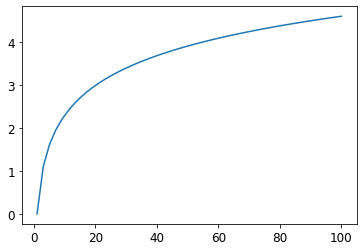

In [ ]:
plot_function(torch.log, min=-100,max=100)

In [ ]:
a = torch.tensor([[-2],[0]])
torch.log(a)

tensor([[nan],
        [-inf]])

16. What are two good rules of thumb for picking a learning rate from the learning rate finder?

  Learning rate finder idea:
    - start with a very very small learning rate, something so small we would never expect it to be too big to converge
    - use that for one mini batch, find what the losses are afterwards and then increase the learning rate by some percentage each time (e.g., double it each time)
    - do another mini batch, track the loss, double the learning rate again
    - keep doing this until the loss gets worse instead of better

  To choose the learning rate one of two choices are suggested:
    - one order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
    - the last point where the loss was clearly decreasing
    
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.